In [8]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('original_data.csv')

# Select the relevant features for clustering
X = data[['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate', 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate']]

# Standardize the features (important for DBSCAN)
X_scaled = StandardScaler().fit_transform(X)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples based on your dataset characteristics
labels = dbscan.fit_predict(X_scaled)

# Identify points which form the core of a cluster
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Mark non-core points (considered as outliers in DBSCAN)
data['Far_Point'] = ~core_samples_mask

def inject_noise(data, columns, fraction=0.05, noise_level=0.50):
    poisoned_data = data.copy()
    num_rows = len(data)
    num_poisoned = int(num_rows * fraction)

    for col in columns:
        std_val = poisoned_data[col].std()
        noise = np.random.normal(0, std_val * noise_level, num_rows)
        indices = np.random.choice(poisoned_data.index, size=num_poisoned, replace=False)
        poisoned_data.loc[indices, col] += noise[indices]
    
    return poisoned_data

columns_to_add_noise = ['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate', 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate']

noised_data = inject_noise(data, columns_to_add_noise)

# Mark outliers in separate boolean columns
for col in columns_to_add_noise:
    noised_data[f'{col}_Outlier'] = noised_data['Far_Point']

print(noised_data.head())
noised_data.to_csv('noise_data_with_boolean_outliers_0.05 and 0.50.csv', index=False)

   Tot_Benes  Tot_Srvcs  Avg_Mdcr_Stdzd_Amt  \
0         28       32.0              581.89   
1         29       38.0              771.93   
2         11       12.0              562.18   
3         13       22.0              117.75   
4         12       16.0              588.58   

   Tot_Benes_standard_normal_variate  Tot_Srvcs_standard_normal_variate  \
0                          -0.112141                           0.245915   
1                          -0.083824                          -0.108504   
2                          -0.593523                          -0.554231   
3                          -0.536889                          -0.382798   
4                          -0.565206                          -0.485658   

   Avg_Mdcr_Stdzd_Amt_standard_normal_variate  Far_Point  \
0                                   -0.124550      False   
1                                    1.229521      False   
2                                   -0.264987      False   
3                         

Not enough clusters formed for meaningful centroid calculation.


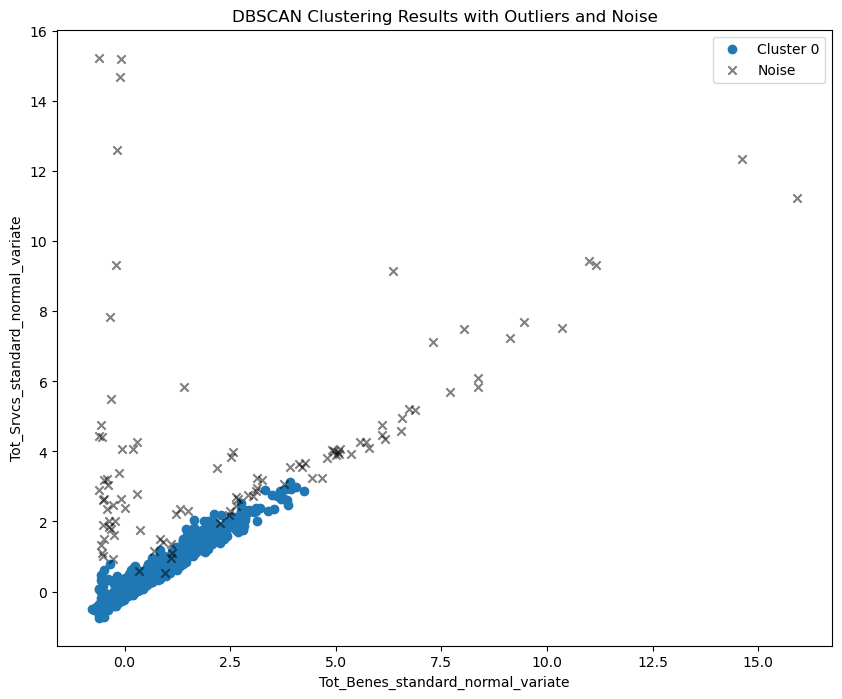

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestCentroid

# Read the data from a CSV file
data = pd.read_csv('noise_data_with_boolean_outliers_0.01 and 0.100.csv')

# Apply DBSCAN clustering to the data
X = data[['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate', 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate']]
dbscan = DBSCAN(eps=0.5, min_samples=10)
data['Cluster'] = dbscan.fit_predict(X)

# Determine if a point is noise
data['Is_Noise'] = data['Cluster'] == -1

# Check if there are enough clusters to calculate centroids
unique_clusters = set(data['Cluster']) - {-1}  # Exclude noise points
if len(unique_clusters) > 1:
    centroid_calculator = NearestCentroid()
    non_noise_data = X[data['Cluster'] != -1]
    non_noise_labels = data[data['Cluster'] != -1]['Cluster']
    centroid_calculator.fit(non_noise_data, non_noise_labels)
    centroids = centroid_calculator.centroids_

    # Calculate the distance of each point to its centroid
    distances = np.sqrt(((non_noise_data - centroids[non_noise_labels.values, :]) ** 2).sum(axis=1))
    threshold = np.percentile(distances, 95)
    data['Is_Outlier'] = distances > threshold
else:
    # Handle case where not enough clusters are formed
    print("Not enough clusters formed for meaningful centroid calculation.")
    data['Is_Outlier'] = False  # Optionally set all to not outliers or handle differently

# Plotting
plt.figure(figsize=(10, 8))

# Plot non-outliers
for cluster_id in unique_clusters:
    cluster_data = data[(data['Cluster'] == cluster_id) & (~data['Is_Outlier'])]
    plt.scatter(cluster_data['Tot_Benes_standard_normal_variate'], 
                cluster_data['Tot_Srvcs_standard_normal_variate'], 
                label=f'Cluster {cluster_id}')

# Optionally plot outliers if calculated
if 'Is_Outlier' in data.columns and data['Is_Outlier'].any():
    outliers = data[data['Is_Outlier']]
    plt.scatter(outliers['Tot_Benes_standard_normal_variate'], 
                outliers['Tot_Srvcs_standard_normal_variate'], 
                c='red', label='Outliers', edgecolors='black')

# Plot noise points
noise_data = data[data['Is_Noise']]
plt.scatter(noise_data['Tot_Benes_standard_normal_variate'], 
            noise_data['Tot_Srvcs_standard_normal_variate'], 
            c='black', label='Noise', marker='x', alpha=0.5)

# Set labels and title
plt.xlabel('Tot_Benes_standard_normal_variate')
plt.ylabel('Tot_Srvcs_standard_normal_variate')
plt.legend()
plt.title('DBSCAN Clustering Results with Outliers and Noise')
plt.show()